## PJM On-Peak Basis Forecast Model

In this project, we aim to construct a Machine Learning model that forecasts the PJM Day-Ahead on-peak basis. After 5 PM on any given day, suppose we have the following information:
- The RT basis before 5 PM
- The whole day DA basis for tomorrow
- The load forecast for the day after tomorrow. 

With this input data, we will train a model that predicts the on-peak basis for the day after tomorrow. Currently, the goal is to setup a baseline model that can be improved down the road.

## Data Exploration and Preprocessing

The input dataset is extremely large and convoluted. Before we begin training the model, we need to experiment with some approaches to aggregate the input data and reduce the dimensionality of the feature space. Here are some ideas:
- Reduce the input hourly data by averaging together offpeak (0-7) and on-peak hours (8-23) separately 
- Only consider columns AP-AS of the raw data, which correspond to Mid-Atlantic, Southern, Western, and RTO Load Forecast combined averages.
- Shift the data so that the inputs align correctly with their predicted values.

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.simplefilter("ignore")

pred_index = 5
abbreivations = ['EDGE_DA', "STC_DA", 'PEACH_DA', 'DPL_DA', 'PPL_DA', 'PECO_DA', 'PPL_PECO_DA']

input_path = "./Input Data/"
file_path = os.path.join(input_path, "basis_forecast.xlsx")

data = pd.read_excel(file_path, skiprows=1)
da_basis = data.iloc[:, :9]  # Columns A:I
rt_basis = data.iloc[:, 10:20]  # Columns K:T
load_forecast = data.iloc[:, [21, 41, 42, 43, 44]]  # Columns V, AP, AQ, AR, AS

rt_basis.rename(columns={"Date/Time.1": "Date/Time"}, inplace=True)
load_forecast.rename(columns={"Date/Time.2": "Date/Time"}, inplace=True)


In [180]:
def extract_date_hour(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts date and hour information from the first column of a DataFrame containing
    datetime values in the format '%m/%d/%Y %H:%M' and adds them as new columns at the
    beginning of the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a datetime column.

    Returns:
        pd.DataFrame: A modified DataFrame with 'Date' and 'Hour' columns inserted at
        the beginning, derived from the datetime values in the first column.
    """
    first_column = df["Date/Time"]

    df.insert(0, "Hour", pd.to_datetime(first_column, format='%m/%d/%Y %H:%M').dt.hour) 
    df.insert(0, "Date", pd.to_datetime(first_column, format='%m/%d/%Y %H:%M').dt.date) 

    df = df.drop(columns=["Date/Time"])
    return df

def onpeak_averages(df: pd.DataFrame, max_hour=23) -> pd.DataFrame:
    result_df = df[df['Hour'].between(8, max_hour)].groupby('Date').mean()
    result_df.reset_index(inplace=True)

    return result_df

In [181]:
da_basis = extract_date_hour(da_basis)
rt_basis = extract_date_hour(rt_basis)
load_forecast = extract_date_hour(load_forecast)

da_basis_avg = onpeak_averages(da_basis)
rt_basis_avg_5 = onpeak_averages(rt_basis, 17)
load_forecast_avg = onpeak_averages(load_forecast)

In [182]:
filtered_da_basis = da_basis_avg.drop(columns=["Hour", "WESTERN HUB (DALMP) Average"])
filtered_rt_basis = rt_basis_avg_5.drop(columns=["Hour", "WESTERN HUB (RTLMP) Average", "DOM (RTLMP) Average"])
filtered_load = load_forecast_avg.drop(columns=["Hour"])

y_pred = filtered_da_basis.iloc[:, [0, pred_index]]
y_pred

,Date,PPL (DALMP ) - WESTERN HUB (DALMP )
0,2023-03-02,-4.002253
1,2023-03-03,-2.665954
2,2023-03-04,-4.013960
3,2023-03-05,-3.195029
4,2023-03-06,-5.572445
...,...,...
179,2023-08-28,-16.357958
180,2023-08-29,-12.397914
181,2023-08-30,-7.481840
182,2023-08-31,-6.730649


In [183]:
"""
Begin the process of merging together the dataframes to one large matrix. if we want to predict day x, align the matrices so that the columns correspond to
    - The y-variable (actual DA basis) for day x
    - The seven columns of RT basis (onpeak averages before 5 PM) corresponding to day x-2
    - The three columns of Load Forecast for day x
    - The seven columns of whole day DA basis (onpeak averages) for day x-1
"""
aligned_rt_basis = filtered_rt_basis.copy()
aligned_rt_basis['Date'] = aligned_rt_basis['Date'] - pd.DateOffset(days=2)

aligned_da_basis = filtered_da_basis.copy()
aligned_da_basis['Date'] = aligned_da_basis['Date'] - pd.DateOffset(days=1)

aligned_da_basis['Date'] = pd.to_datetime(aligned_da_basis['Date'])
aligned_rt_basis['Date'] = pd.to_datetime(aligned_rt_basis['Date'])
y_pred['Date'] = pd.to_datetime(y_pred['Date'])
filtered_load['Date'] = pd.to_datetime(filtered_load['Date'])

merged_df = pd.merge(aligned_da_basis, aligned_rt_basis, on='Date', how='inner')
merged_df = pd.merge(merged_df, y_pred, on='Date', how='inner')
merged_df = pd.merge(merged_df, filtered_load, on='Date', how='inner')

## Abbreviate the column names
new_column_names = {
    'EDGEMOOR 13 KV HAYRD5 (DALMP ) - WESTERN HUB (DALMP )': "EDGE_DA",
    'STEEL CITY 4CC (DALMP ) - WESTERN HUB (DALMP )': "STC_DA",
    "PPL (DALMP ) - PECO (DALMP )": "PPL_PECO_DA",
    'PEACHBOT 22 KV UNIT02 (DALMP ) - WESTERN HUB (DALMP )': "PEACH_DA",
    'DPL (DALMP ) - WESTERN HUB (DALMP )': "DPL_DA",
    'PPL (DALMP ) - WESTERN HUB (DALMP )': "PPL_DA",
    'PECO (DALMP ) - WESTERN HUB (DALMP )': "PECO_DA",
    'EDGEMOOR 13 KV HAYRD5 (RTLMP ) - WESTERN HUB (RTLMP )': "EDGE_RT",
    'STEEL CITY 4CC (RTLMP ) - WESTERN HUB (RTLMP )': "STC_RT",
    'PEACHBOT 22 KV UNIT02 (RTLMP ) - WESTERN HUB (RTLMP )': "PEACH_RT",
    'DPL (RTLMP ) - WESTERN HUB (RTLMP )': "DPL_RT",
    'PPL (RTLMP ) - WESTERN HUB (RTLMP )': "PPL_RT",
    'PECO (RTLMP ) - WESTERN HUB (RTLMP )': "PECO_RT",
    'DOM (RTLMP ) - WESTERN HUB (RTLMP )': "DOM_RT",
    'SOUTHERN REGION (BIDCLOSE_LOAD_FORECAST) Average': "SOUTH_L",
    'WESTERN REGION (BIDCLOSE_LOAD_FORECAST) Average': "WEST_L",
    "MID-ATLANTIC REGION (BIDCLOSE_LOAD_FORECAST) Average": "MID_AT_L",
    'RTO COMBINED (BIDCLOSE_LOAD_FORECAST) Average': "RTO_L",
    filtered_da_basis.columns[pred_index] + "_x": abbreivations[pred_index - 1] + "_x",
    filtered_da_basis.columns[pred_index] + "_y": abbreivations[pred_index - 1] + "_y"
}
merged_df.rename(columns=new_column_names, inplace=True)
merged_df

,Date,EDGE_DA,STC_DA,PEACH_DA,DPL_DA,PPL_DA_x,PECO_DA,PPL_PECO_DA,EDGE_RT,STC_RT,PEACH_RT,DPL_RT,PPL_RT,PECO_RT,DOM_RT,PPL_DA_y,MID_AT_L,SOUTH_L,WEST_L,RTO_L
0,2023-03-02,-5.699907,-4.164907,-5.024282,-5.370517,-2.665954,-5.550337,2.884383,-4.455089,-3.256089,-3.920089,-4.464301,-2.551873,-4.276279,0.593465,-4.002253,29587.3125,12160.8750,46643.5625,88391.7500
1,2023-03-03,-6.891482,-5.338982,-5.978357,-6.159625,-4.013960,-6.782493,2.768533,-4.163170,-3.201170,-3.648170,-4.155714,-2.661704,-4.133757,0.656563,-2.665954,32213.9375,13030.6875,47585.5000,92872.9375
2,2023-03-04,-5.150585,-3.925585,-4.559335,-4.720920,-3.195029,-5.111387,1.916358,-18.010050,-12.555050,-16.864050,-18.842054,-8.956149,-17.522332,1.528732,-4.013960,29162.0000,11616.0000,43177.9375,83955.9375
3,2023-03-05,-10.824295,-7.633045,-10.318670,-10.586316,-5.572445,-10.567663,4.995217,-5.390208,-3.506208,-5.138208,-5.162551,-2.375615,-4.974634,0.619508,-3.195029,28106.5625,11899.8125,42125.0625,82131.6875
4,2023-03-06,-11.238461,-7.679086,-10.512836,-10.168993,-5.271303,-10.836789,5.565486,-6.675416,-4.325416,-6.360416,-6.641052,-3.001893,-6.259838,0.833252,-5.572445,30485.1875,12661.8125,46351.1250,89498.1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,2023-08-26,-13.562325,-13.369825,-13.556700,-9.020820,-14.854803,-12.852762,-2.002041,-5.447907,-4.593907,-5.119907,-4.628343,-3.850061,-5.063865,1.223099,-15.696769,37176.6250,17103.1250,52784.0625,107063.8125
178,2023-08-27,-16.828261,-15.680761,-16.435136,-15.948193,-16.357958,-16.524892,0.166935,-1.826841,-1.842841,-1.862841,-0.809598,-1.712448,-1.430398,0.477316,-14.854803,34232.7500,15410.6875,46721.5625,96365.0000
179,2023-08-28,-12.468041,-18.844916,-12.204291,-9.414580,-12.397914,-11.955101,-0.442812,-2.315178,-1.898178,-2.025178,-1.567272,-1.276480,-2.065026,1.079419,-16.357958,35672.6250,15111.6250,52011.9375,102796.1875
180,2023-08-29,-8.507473,-8.989348,-8.597473,-0.234348,-7.481840,-7.672713,0.190873,-10.668726,-7.622726,-9.474726,-11.235153,-5.584388,-10.721545,1.593029,-12.397914,36962.6875,16250.8125,52445.1250,105658.6250


### Create training, testing split and visualize the input data.

In [184]:
from sklearn.model_selection import train_test_split

X = merged_df.drop([abbreivations[pred_index - 1] + "_y"], axis=1)
y = merged_df[abbreivations[pred_index - 1] + "_y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = X_train.drop(columns=["Date"], axis=1)
train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

train_data

,EDGE_DA,STC_DA,PEACH_DA,DPL_DA,PPL_DA_x,PECO_DA,PPL_PECO_DA,EDGE_RT,STC_RT,PEACH_RT,DPL_RT,PPL_RT,PECO_RT,DOM_RT,MID_AT_L,SOUTH_L,WEST_L,RTO_L,PPL_DA_y
117,-13.434650,-11.713400,-12.778400,-13.018915,-10.834130,-13.085206,2.251076,-2.581661,-3.247661,-2.700661,-1.635072,-4.580317,-2.176989,0.718101,35820.2500,15597.3750,49833.2500,101250.8750,-8.689329
38,-9.342288,-8.284163,-8.797913,-8.711451,-7.686425,-9.316349,1.629924,-2.131123,-1.573123,-1.921123,-1.642961,-1.060847,-1.760696,1.479213,24564.7500,11175.5625,36373.8125,72114.1250,-3.658283
118,-16.977534,-14.844409,-17.883159,-15.782518,-14.281559,-15.572280,1.290721,-1.759155,-1.966155,-1.756155,-0.544273,-2.264407,-1.238535,0.425552,35226.6250,15436.4375,52452.8750,103115.9375,-10.834130
150,-13.894082,-12.947832,-13.275332,-10.204595,-11.715889,-13.362364,1.646476,-6.738349,-5.555349,-6.032349,-6.604240,-4.990300,-6.583145,1.158008,36413.0625,16816.6250,50585.0625,103814.7500,-14.661146
75,-12.451715,-8.806715,-10.442340,-13.212946,-6.250555,-12.489824,6.239269,-5.353063,-3.484063,-4.207063,-5.305118,-2.631785,-4.264317,-0.079573,29858.1250,13178.7500,44433.3125,87490.6250,-6.382278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-13.818440,-11.899690,-12.822815,-13.831213,-11.584487,-13.618791,2.034304,-17.816074,-13.241074,-17.141074,-18.513098,-10.082843,-17.354331,2.656836,30742.1250,14579.8750,45417.1875,90739.1875,-6.499629
14,-6.297615,-4.957615,-5.806365,-5.854383,-3.916151,-6.427256,2.511105,-0.439670,-0.252670,-0.387670,0.157541,-0.265741,-0.189779,0.810021,30356.9375,12737.7500,47901.3125,90996.0000,-2.605247
92,-20.994278,-15.612403,-18.038028,-21.877850,-12.565757,-21.461121,8.895364,-8.082913,-5.823913,-6.767913,-8.822162,-4.393190,-8.236533,1.401168,37436.6250,14565.1875,58901.8750,110903.6875,-13.009967
179,-12.468041,-18.844916,-12.204291,-9.414580,-12.397914,-11.955101,-0.442812,-2.315178,-1.898178,-2.025178,-1.567272,-1.276480,-2.065026,1.079419,35672.6250,15111.6250,52011.9375,102796.1875,-16.357958


In [185]:
test_data.head(5)

,Date,EDGE_DA,STC_DA,PEACH_DA,DPL_DA,PPL_DA_x,PECO_DA,PPL_PECO_DA,EDGE_RT,STC_RT,PEACH_RT,DPL_RT,PPL_RT,PECO_RT,DOM_RT,MID_AT_L,SOUTH_L,WEST_L,RTO_L,PPL_DA_y
19,2023-03-21,-6.118370,-4.708370,-5.474620,-5.542657,-3.779581,-5.922260,2.142679,-0.955876,-0.291876,-1.088876,-0.261812,-0.303222,-0.349750,41.776715,29575.0000,13080.0000,47141.0000,89796.0000,-5.162597
42,2023-04-13,-7.890069,-7.873194,-8.271319,-6.629091,-8.541032,-7.120086,-1.420946,-3.023367,-3.099368,-3.348367,-2.141761,-3.508810,-2.270368,0.836274,32787.1875,12852.1875,45840.5000,91479.8750,-8.438566
154,2023-08-03,-14.376393,-12.757018,-14.352643,-12.994055,-12.962393,-13.583123,0.620730,-4.557206,-4.051206,-5.317206,-3.651486,-3.691603,-3.841237,1.067373,36482.6250,15796.3750,58637.0000,110916.0000,-11.670878
98,2023-06-08,-9.904522,-7.361397,-8.155147,-10.526147,-5.275781,-10.262123,4.986342,-9.704627,-7.133627,-9.830627,-9.743078,-5.239051,-9.094832,1.564276,29440.7500,13050.9375,44550.6875,87042.3750,-6.316404
146,2023-07-26,-33.764911,-35.035536,-34.462411,12.384528,-30.829326,-29.461733,-1.367593,2.632674,2.508674,2.422674,4.721084,3.430165,3.527798,6.835243,43475.0000,17971.9375,66171.0000,127640.5625,-14.725091


array([[<AxesSubplot:title={'center':'EDGE_DA'}>,
        <AxesSubplot:title={'center':'STC_DA'}>,
        <AxesSubplot:title={'center':'PEACH_DA'}>,
        <AxesSubplot:title={'center':'DPL_DA'}>],
       [<AxesSubplot:title={'center':'PPL_DA_x'}>,
        <AxesSubplot:title={'center':'PECO_DA'}>,
        <AxesSubplot:title={'center':'PPL_PECO_DA'}>,
        <AxesSubplot:title={'center':'EDGE_RT'}>],
       [<AxesSubplot:title={'center':'STC_RT'}>,
        <AxesSubplot:title={'center':'PEACH_RT'}>,
        <AxesSubplot:title={'center':'DPL_RT'}>,
        <AxesSubplot:title={'center':'PPL_RT'}>],
       [<AxesSubplot:title={'center':'PECO_RT'}>,
        <AxesSubplot:title={'center':'DOM_RT'}>,
        <AxesSubplot:title={'center':'MID_AT_L'}>,
        <AxesSubplot:title={'center':'SOUTH_L'}>],
       [<AxesSubplot:title={'center':'WEST_L'}>,
        <AxesSubplot:title={'center':'RTO_L'}>,
        <AxesSubplot:title={'center':'PPL_DA_y'}>, <AxesSubplot:>]],
      dtype=object)

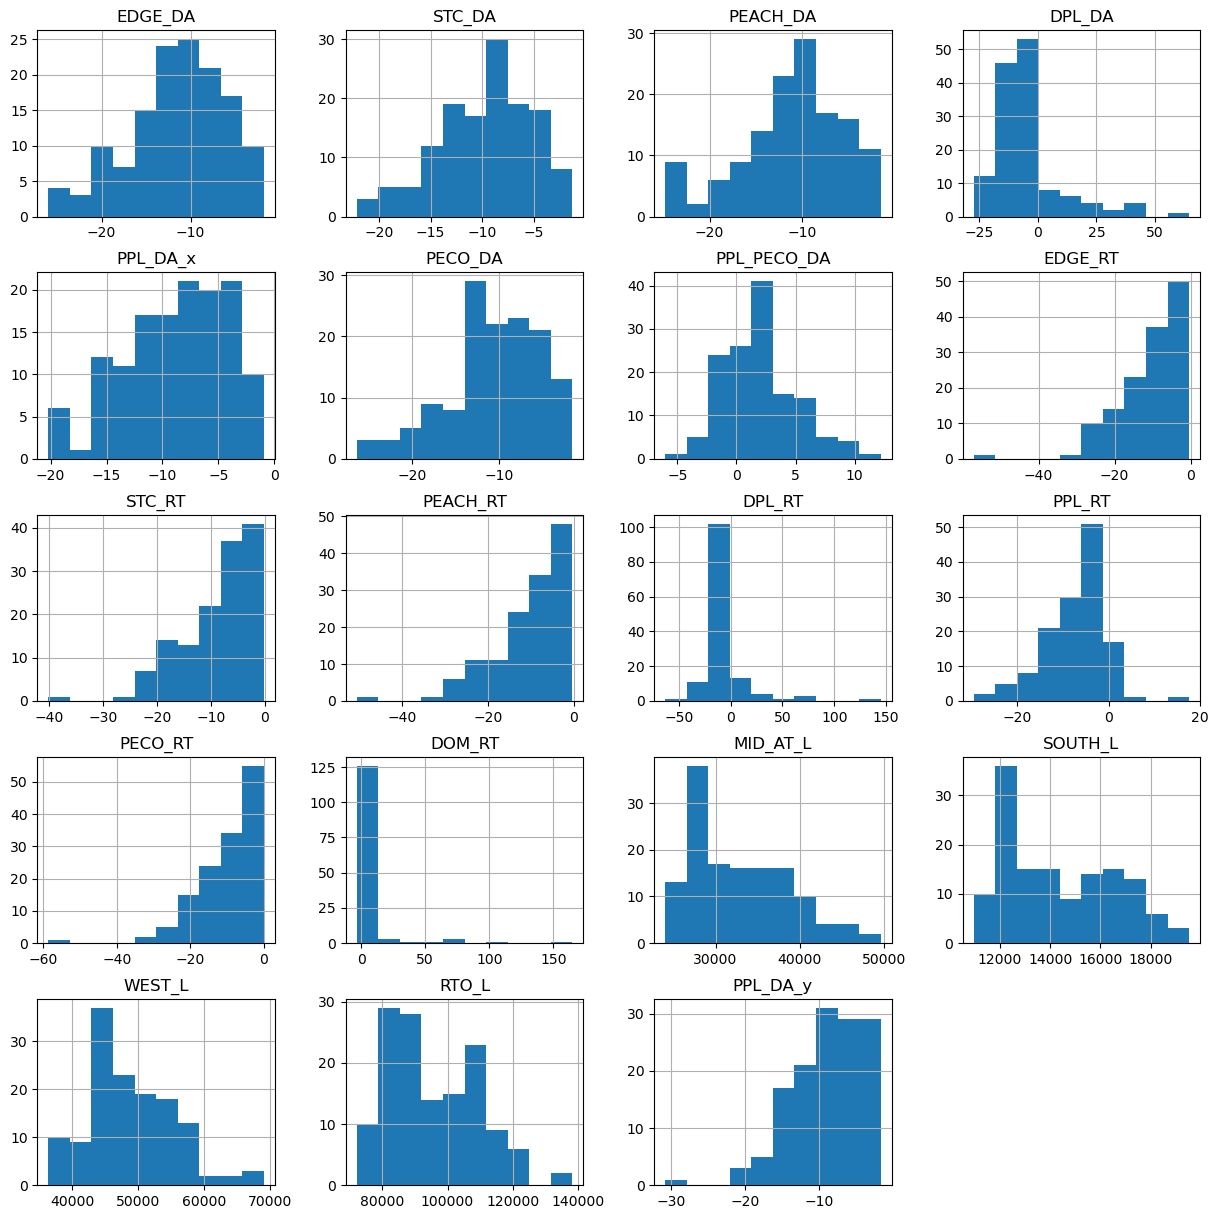

In [186]:
train_data.hist(figsize=(15, 15))

<AxesSubplot:>

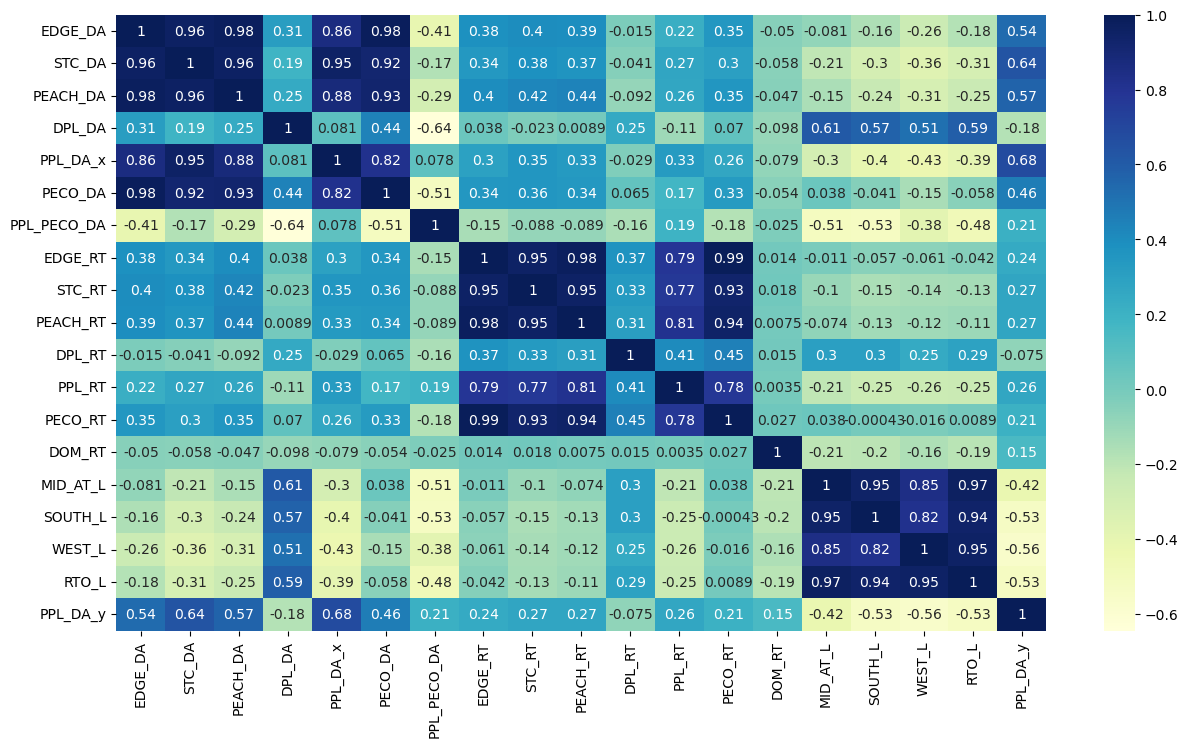

In [187]:
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(), annot=True, cmap="YlGnBu")

## Model Building

- We start with a basic linear regression model
- Then, we move on to a machine learning random forest model

### LASSO Regression

In [188]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Scale the input data
scaler = StandardScaler()
x_train, y_train = train_data.drop([abbreivations[pred_index - 1] + "_y"], axis=1), train_data[abbreivations[pred_index - 1] + "_y"]
X_train_s = scaler.fit_transform(x_train)

X_dates = test_data["Date"]
X_test_no_date = X_test.drop(["Date"], axis=1)
X_test_s = scaler.transform(X_test_no_date) 

# Fit a Lasso Regression model
alpha = 0.05
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train_s, y_train)


Lasso(alpha=0.05)

In [189]:
lasso_score = round(lasso_reg.score(X_test_s, y_test), 3)
lasso_score

0.511

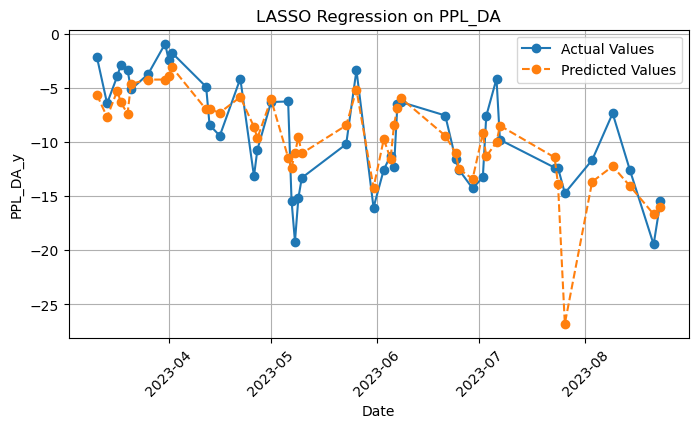

In [190]:
def plot_predictions(model, X_test, y_test, title):
    y_pred = model.predict(X_test)

    result_df = pd.DataFrame()
    result_df['Date'] = X_dates
    result_df['Actual'] = y_test
    result_df['Predicted'] = y_pred
    result_df = result_df.sort_values(by='Date')

    plt.figure(figsize=(8, 4))
    plt.plot(result_df['Date'], result_df['Actual'], label='Actual Values', marker='o', linestyle='-')
    plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted Values', marker='o', linestyle='--')
    plt.xlabel('Date')
    plt.title(title)
    plt.ylabel(abbreivations[pred_index - 1] + "_y")
    plt.legend()
    plt.xticks(rotation=45) 
    plt.grid(True)

    return plt

plot_lasso = plot_predictions(lasso_reg, X_test_s, y_test, "LASSO Regression on " + abbreivations[pred_index - 1])
plot_lasso.show()

### Random Forest Regression

In [191]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train_s, y_train)

RandomForestRegressor()

In [192]:
forest_score = round(forest.score(X_test_s, y_test), 3)
forest_score

0.616

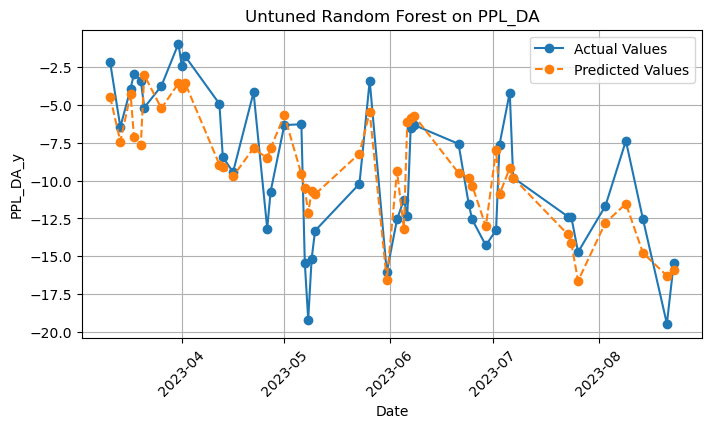

In [193]:
# Plot the predictions from the Random Forest Model (no hyperparameter tuning)
plot_rf = plot_predictions(forest, X_test_s, y_test, "Untuned Random Forest on " + abbreivations[pred_index - 1])
plot_rf.show()

In [194]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100],
    "max_features": ['auto', 0.4],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
grid_search = GridSearchCV(forest, param_grid, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train_s, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10], 'max_features': ['auto', 0.4],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [195]:
best_forest = grid_search.best_estimator_
best_forest

RandomForestRegressor(max_features=0.4, min_samples_leaf=2, min_samples_split=5)

In [196]:
best_forest_score = round(best_forest.score(X_test_s, y_test), 3)
best_forest_score

0.662

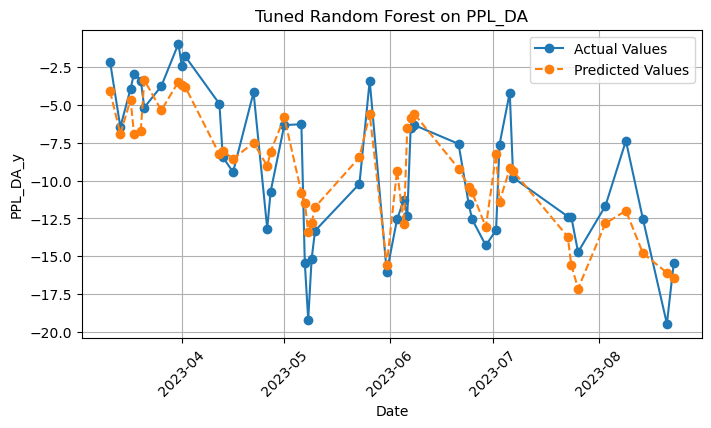

In [197]:
plot_best_rf = plot_predictions(best_forest, X_test_s, y_test, "Tuned Random Forest on " + abbreivations[pred_index - 1])
plot_best_rf.show()

### Neural Network

Ideally, we would like to have a lot more training data for a NN to be most effective. Currently, we have less than 150 training data points,  which isn't quite enough to generate the most nuanced predictions. 
Still good to have though.

In [210]:
from sklearn.neural_network import MLPRegressor

neural = MLPRegressor(random_state=420, learning_rate_init = 0.05, max_iter=500).fit(X_train_s, y_train)
neural_score = round(neural.score(X_test_s, y_test), 3)
neural_score

0.265

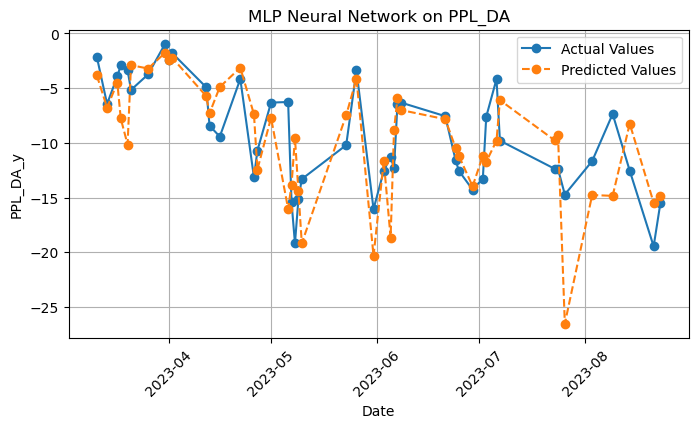

In [211]:
plot_best_rf = plot_predictions(neural, X_test_s, y_test, "MLP Neural Network on " + abbreivations[pred_index - 1])
plot_best_rf.show()

## Conclusions


In [212]:
print("LASSO Coefficient of Determination: ", lasso_score)
print("Untuned Random Forest Coefficient of Determination: ", forest_score)
print("Tuned Random Forest Coefficient of Determination: ", best_forest_score)
print("Neural Network Coefficient of Determination: ", neural_score)

LASSO Coefficient of Determination:  0.511
Untuned Random Forest Coefficient of Determination:  0.616
Tuned Random Forest Coefficient of Determination:  0.662
Neural Network Coefficient of Determination:  0.265
